In [18]:
import rasterio as rio

In [19]:
from glob import glob
import os
from os.path import join, basename, dirname, exists
import numpy as np
from osgeo import gdal
from subprocess import Popen, PIPE, run
from uavsar_pytools.uavsar_tools import read_annotation
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
import numpy as np

In [20]:
def command(cmd):
    result = run(cmd, stdout=PIPE, stderr=PIPE, universal_newlines=True)
    print(result.returncode, result.stdout, result.stderr)

In [21]:
start = '/home/jovyan/work/'
work = '/home/jovyan/work/merge'
unw_d = '/home/jovyan/work/merge/unw'

get unique pairs

In [22]:
igram_pairs = np.unique([f.split('/')[-2] for f in glob(join(start,'*/Igrams/*/'))])

parse lat, long, elev data

In [23]:
dt = np.dtype('<f')
rows = 4427
cols = 8090
print(rows*cols)
llh = {}
for i, f in enumerate(glob(join(start, f'*/downloadHH/*.llh'))):
    d = {}
    track_d = f.split('/')[-3]
    arr = np.fromfile(f, dtype = dt)
    ann = join(start,track_d,'SLC','*')
    ann = (glob(join(glob(ann)[0],'*.ann')))
    ann = read_annotation(ann[0])
    trackn = track_d.split('_')[1][1]
    rows = ann[f'llh_{trackn}_2x8.set_rows']['value']
    cols = ann[f'llh_{trackn}_2x8.set_cols']['value']
    lat = arr[0::3].reshape(rows, cols)
    lon = arr[1::3].reshape(rows, cols)
    ele = arr[2::3].reshape(rows, cols)
    d['lat'] = lat
    d['lon'] = lon
    d['ele'] = ele
    llh[track_d] = d

35814430


In [24]:
# for pDates in igram_pairs:
#     for f in glob(join(start, f'*/*/*/*.slc')):
# #         cmd = ['rm', f]
# #         command(cmd)

cell above to delete files. cell below inserts xml data to geolocation from lat long

In [25]:
text = """  <Metadata domain="GEOLOCATION">
      <MDI key="X_DATASET">/home/jovyan/work/Lowman_t1/Igrams/20200131_20200213/lon.vrf</MDI>
      <MDI key="X_BAND">1</MDI>
      <MDI key="Y_DATASET">/home/jovyan/work/Lowman_t1/Igrams/20200131_20200213/lat.vrf</MDI>
      <MDI key="Y_BAND">1</MDI>
      <MDI key="PIXEL_OFFSET">0</MDI>
      <MDI key="LINE_OFFSET">0</MDI>
      <MDI key="PIXEL_STEP">1</MDI>
      <MDI key="LINE_STEP">1</MDI>
    </Metadata>\n"""
def insert_text(f, text, index=1):
    with open(f, 'r') as vrt:
        contents = vrt.readlines()
    if 'X_DATASET' not in contents:
        contents.insert(index,text)
        with open(f, "w") as vrt:
            contents = "".join(contents)
            vrt.write(contents)
    else:
        print('already amended')

cell below saves out lat, long tiffs

In [32]:
import rasterio
for pDates in igram_pairs:
    for img_type in ['unw','cor']:
        for f in glob(join(start, f'*/Igrams/{pDates}/*.{img_type}.vrt')):
            # print(f)
            track_d = f.split('/')[4]
            print(track_d)
            #gdal_translate -of GTiff -a_srs 'EPSG:<4326>' -a_ullr <upper left x> <upper left y> <lower right x> <lower right y> <img_path> <dest_img>
            for direction in ['lat','lon']:
                Z = llh[track_d][direction]
                with rasterio.open(join(dirname(f),direction+'.tif'),'w',driver='GTiff',height=Z.shape[0],width=Z.shape[1],count=1,dtype=Z.dtype,
                crs='+proj=latlong') as dst:
                    dst.write(Z, 1)


Lowman_t3


/home/jovyan/.local/envs/unavco/lib/python3.8/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,


Lowman_t2
Lowman_t1
Lowman_t3
Lowman_t2
Lowman_t1
Lowman_t3
Lowman_t2
Lowman_t1
Lowman_t3
Lowman_t2
Lowman_t1
Lowman_t3
Lowman_t2
Lowman_t1
Lowman_t3
Lowman_t2
Lowman_t1
Lowman_t3
Lowman_t2
Lowman_t1
Lowman_t3
Lowman_t2
Lowman_t1
Lowman_t3
Lowman_t2
Lowman_t1
Lowman_t3
Lowman_t2
Lowman_t1
Lowman_t3
Lowman_t2
Lowman_t1
Lowman_t3
Lowman_t2
Lowman_t1


cell below geolocates data using lat long geolocation array

In [34]:
for img_type in ['unw','cor']:
    for pDates in igram_pairs:
        os.makedirs(join(work,pDates), exist_ok = True)
        for f in glob(join(start, f'*/Igrams/{pDates}/*.{img_type}.vrt')):
                text = f"""  <Metadata domain="GEOLOCATION">
              <MDI key="X_DATASET">{dirname(f)}/lon.vrf</MDI>
              <MDI key="X_BAND">1</MDI>
              <MDI key="Y_DATASET">{dirname(f)}/lat.vrf</MDI>
              <MDI key="Y_BAND">1</MDI>
              <MDI key="PIXEL_OFFSET">0</MDI>
              <MDI key="LINE_OFFSET">0</MDI>
              <MDI key="PIXEL_STEP">1</MDI>
              <MDI key="LINE_STEP">1</MDI>
            </Metadata>\n"""
                insert_text(f, text)
        #         print(f)
                unw_merge_dir = (join(work, pDates, img_type))
                os.makedirs(unw_merge_dir, exist_ok = True)
                track_d = f.split('/')[4]
                #gdal_translate -of GTiff -a_srs 'EPSG:<4326>' -a_ullr <upper left x> <upper left y> <lower right x> <lower right y> <img_path> <dest_img>
                ul_y = llh[track_d]['lat'][0][0]
                br_x = llh[track_d]['lon'][0][0]
                br_y = llh[track_d]['lat'][-1][-1]
                ul_x = llh[track_d]['lon'][-1][-1]
                in_fp = f
                out_fp = f.replace('.vrt','.wgs84.tiff')
                cmd = ['gdal_translate',join(dirname(f), 'lat.tif'), join(dirname(f), 'lat.vrf'), '-of','vrt']
                command(cmd)
                cmd = ['gdal_translate',join(dirname(f), 'lon.tif'), join(dirname(f), 'lon.vrf'), '-of','vrt']
                command(cmd)
                if exists(out_fp):
                    command(['rm',out_fp])
                cmd = ['gdalwarp',in_fp, out_fp,'-of','GTiff','-t_srs','EPSG:4326','-geoloc']

        #        cmd = ['gdal_translate',in_fp, out_fp,'-of','GTiff','-a_srs','EPSG:4326','-a_ullr',str(ul_x),str(ul_y),str(br_x),str(br_y)]
        #         cmd = ['gdalwarp','-srcfile', f, '-dstfile' ,f.replace('.vrt','.wgs84.tiff'),'-t_srs','EPSG:4326','s_srs',]
                # print(cmd)
                # print(' '.join(cmd))
                command(cmd)
                cmd = ['cp',out_fp, join(unw_merge_dir,track_d+'_'+basename(out_fp))]
        #         cmd = ['gdalwarp','-srcfile', f, '-dstfile' ,f.replace('.vrt','.wgs84.tiff'),'-t_srs','EPSG:4326','s_srs',]
                # print(cmd)
                # print(' '.join(cmd))
                command(cmd)


0 Input file size is 4427, 8090
 
0 Input file size is 4427, 8090
 
0  
0 Creating output file that is 11547P x 7626L.
Processing /home/jovyan/work/Lowman_t3/Igrams/20200131_20200213/filt_20200131_20200213_icu.unw.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
 ERROR 1: Too many points (529 out of 529) failed to transform, unable to compute output bounds.
Warning 1: Unable to compute source region for output window 0,0,2886,1906, skipping.
ERROR 1: Too many points (529 out of 529) failed to transform, unable to compute output bounds.
Warning 1: Unable to compute source region for output window 8660,5719,2887,1907, skipping.



KeyboardInterrupt: 

In [38]:
for j, f in enumerate(glob(join(work, f'*/'))):

        for i in ['unw','cor']:
            sub_d = join(f,i)
#             os.chdir(sub_d)
#             cmd = ['gdalbuildvrt', 'mosaic.vrt', '*.tiff']
#             print(' '.join(cmd))
#             command(cmd)
    #         tiff_list = glob(join(sub_d, '*.tiff'))
    #         gdal.BuildVRT(join(sub_d,'mosaic.vrt'), tiff_list)
    #         cmd1 = ['gdalbuildvrt', join(sub_d,'mosaic.vrt'), join(sub_d, '*.tiff')]
    #         print(' '.join(cmd1))
    #         command(cmd)

            file_list = glob(join(sub_d, f'*{i}.wgs84.tiff'))
            # file_list = [basename(f) for f in file_list]
            # files_string = " ".join(file_list)
            
            # os.chdir(sub_d)
            
            pairs = f.split('/')[-2]
            out_file = f + f'merged_{pairs}.{i}.tif'
            if i == 'unw':
                out_unw_file = out_file
            #cmd = ["gdal_merge.py", '-o', out_file, '-of', 'gtiff', files_string]
            cmd = ["gdal_merge.py", '-o', out_file, '-of', 'gtiff', '-n', '0']
            cmd.extend(file_list)
            print((cmd))
            command(cmd)

['gdal_merge.py', '-o', '/home/jovyan/work/merge/20200221_20200311/merged_20200221_20200311.unw.tif', '-of', 'gtiff', '-n', '0', '/home/jovyan/work/merge/20200221_20200311/unw/Lowman_t1_filt_20200221_20200311_icu.unw.wgs84.tiff', '/home/jovyan/work/merge/20200221_20200311/unw/Lowman_t2_filt_20200221_20200311_icu.unw.wgs84.tiff', '/home/jovyan/work/merge/20200221_20200311/unw/Lowman_t3_filt_20200221_20200311_icu.unw.wgs84.tiff']
0 0...10...20...30...40...50...60...70...80...90...100 - done.
 
['gdal_merge.py', '-o', '/home/jovyan/work/merge/20200221_20200311/merged_20200221_20200311.cor.tif', '-of', 'gtiff', '-n', '0', '/home/jovyan/work/merge/20200221_20200311/cor/Lowman_t2_filt_20200221_20200311.cor.wgs84.tiff', '/home/jovyan/work/merge/20200221_20200311/cor/Lowman_t1_filt_20200221_20200311.cor.wgs84.tiff', '/home/jovyan/work/merge/20200221_20200311/cor/Lowman_t3_filt_20200221_20200311.cor.wgs84.tiff']
0 0...10...20...30...40...50...60...70...80...90...100 - done.
 ERROR 1: TIFFReadEn

(-2.0, 2.0)

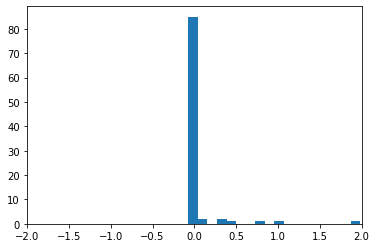

In [48]:
with rio.open('/home/jovyan/work/Lowman_t1/Igrams/20200131_20200213/filt_20200131_20200213_icu.unw.wgs84.tiff') as src:
    arr = src.read(1)[::1000,::1000]
    
plt.hist(arr.ravel(), bins = 30)
plt.xlim(-2,2)

In [31]:
finals = glob(join(work, '*','merged*.tif'))
for im in finals:
    out_fp = f'/home/jovyan/work/merge_v2/'
    cmd = f'cp {im} {out_fp}'
    print(cmd)
#     command(cmd)
    ! cp f'{im}' f'{out_fp}'

cp /home/jovyan/work/merge/20200221_20200311/merged_20200221_20200311.cor.tif /home/jovyan/work/merge_v2/
cp: cannot stat 'f/home/jovyan/work/merge/20200221_20200311/merged_20200221_20200311.cor.tif': No such file or directory
cp /home/jovyan/work/merge/20200221_20200311/merged_20200221_20200311.unw.tif /home/jovyan/work/merge_v2/
cp: cannot stat 'f/home/jovyan/work/merge/20200221_20200311/merged_20200221_20200311.unw.tif': No such file or directory
cp /home/jovyan/work/merge/20200131_20200311/merged_20200131_20200311.cor.tif /home/jovyan/work/merge_v2/
cp: cannot stat 'f/home/jovyan/work/merge/20200131_20200311/merged_20200131_20200311.cor.tif': No such file or directory
cp /home/jovyan/work/merge/20200131_20200311/merged_20200131_20200311.unw.tif /home/jovyan/work/merge_v2/
cp: cannot stat 'f/home/jovyan/work/merge/20200131_20200311/merged_20200131_20200311.unw.tif': No such file or directory
cp /home/jovyan/work/merge/20200213_20200311/merged_20200213_20200311.unw.tif /home/jovyan/w

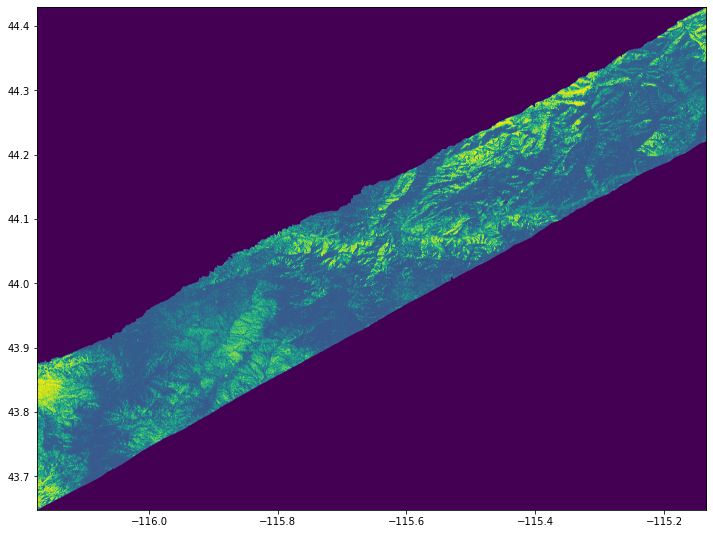

In [15]:
fig, ax = plt.subplots(1,1, figsize=(12,16))
f = '/home/jovyan/work/merge/20200131_20200221/merged_20200131_20200221.cor.tif'
with rio.open(f) as src:
    if 'cor' in f:
        vmin = 0
        vmax = 1
    else:
        arr = src.read(1)
        vmin = np.nanquantile(arr, 0.1)
        vmax = np.nanquantile(arr, 0.9)
    # use imshow so that we have something to map the colorbar to
        image_hidden = ax.imshow(arr, vmin=vmin, vmax=vmax)
        fig.colorbar(image_hidden, ax=ax)
    retted = show(src, vmin = vmin, vmax = vmax, ax = ax)

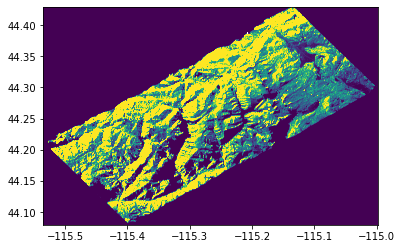

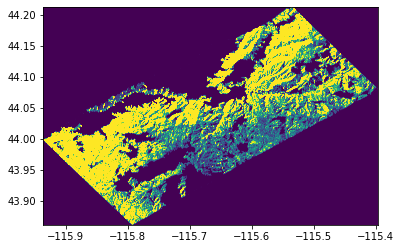

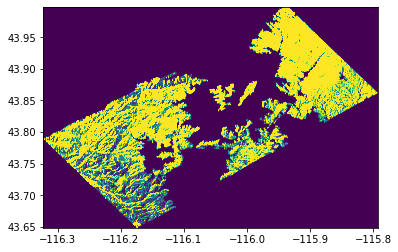

In [456]:
imgs = ['/home/jovyan/work/merge/20200221_20200311/unw/Lowman_t1_filt_20200221_20200311_icu.unw.wgs84.tiff', '/home/jovyan/work/merge/20200221_20200311/unw/Lowman_t2_filt_20200221_20200311_icu.unw.wgs84.tiff', '/home/jovyan/work/merge/20200221_20200311/unw/Lowman_t3_filt_20200221_20200311_icu.unw.wgs84.tiff']
for img in imgs:
    fig, ax = plt.subplots(1,1, figsize=(6,8))
    with rio.open(img) as src:
        if 'cor' in f:
            vmin = 0
            vmax = 1
        else:
            arr = src.read(1)
            vmin = np.nanquantile(arr, 0.1)
            vmax = np.nanquantile(arr, 0.9)
        # arr = src.read(1)
        # use imshow so that we have something to map the colorbar to
        image_hidden = ax.imshow(arr,  
                             vmin=vmin, 
                             vmax=vmax)
        retted = show(src, vmin = vmin, vmax = vmax, ax = ax)
        # fig.colorbar(image_hidden, ax=ax)
    plt.show()

In [16]:
## Clean up merge directory.

# for f in glob(join(start, f'merge/*/*/*.tiff')):
#     print(f)
#     cmd = ['rm', f]
#     command(cmd)

# for f in glob(join(start, f'merge/*/*/*.vrt')):
#     print(f)
#     cmd = ['rm', f]
#     command(cmd)

# for f in glob(join(start, f'merge/*/*/')):
#     print(f)
#     cmd = ['rmdir', f]
#     command(cmd)